# Prototypical Generative Model (PGM) training

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "proto_gen_model.ipynb"
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"

import numpy as np

import jax.random as random
import jax.numpy as jnp

jnp.log(jnp.exp(1) - 1.0)
# TODO: figure out why we get CUDA failures this ^ isn't here. 

import flax
from flax.training import checkpoints

import ciclo
import wandb 

import jax
import flax
flax.config.update('flax_use_orbax_checkpointing', True)

from clu import parameter_overview
from clu import deterministic_data

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

from src.transformations import transform_image
from experiments.configs.pgm_mnist import get_config
from src.utils.input import get_data
from src.models.proto_gen_model import PrototypicalGenerativeModel, create_pgm_state, make_pgm_train_and_eval
from src.models.utils import reset_metrics
from src.utils.plotting import rescale_for_imshow
from src.utils.training import custom_wandb_logger


2023-09-25 04:35:26.589704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
ANGLE = 180
config = get_config(f"{ANGLE}")

In [3]:
print((3 * config.model.generative.num_bins + 1) * len(config.model.bounds), config.model.generative.conditioner.hidden_dims[-1])
# Note, we probably want the first number to be smaller than the second number. Haven't tested this yet.

65 256


In [4]:
run = wandb.init(
    project="iclr2024experiments",
    entity="invariance-learners",
    config=config.to_dict(),
    mode="online",
    notes="",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

wandb: Currently logged in as: jamesallingham (invariance-learners). Use `wandb login --relogin` to force relogin


In [5]:
rng = random.PRNGKey(config.seed)
data_rng, init_rng, state_rng = random.split(rng, 3)

## Get data

In [6]:
jax.local_device_count()

1

In [7]:
train_ds, val_ds, _ = get_data(config, data_rng)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)


INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, dro

## Setup TrainState and NN

In [8]:
model = PrototypicalGenerativeModel(**config.model.to_dict())

variables = model.init({'params': init_rng, 'sample': init_rng}, jnp.empty((28, 28, 1)), train=False)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+----------------------------------------------------+-------------+---------+-----------+--------+
| Name                                               | Shape       | Size    | Mean      | Std    |
+----------------------------------------------------+-------------+---------+-----------+--------+
| params/generative_net/Conditioner_0/Dense_0/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/generative_net/Conditioner_0/Dense_0/kernel | (256, 256)  | 65,536  | 9.69e-05  | 0.0627 |
| params/generative_net/Conditioner_0/Dense_1/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/generative_net/Conditioner_0/Dense_1/kernel | (256, 256)  | 65,536  | -0.000112 | 0.0624 |
| params/generative_net/Conditioner_0/Dense_2/bias   | (65,)       | 65      | 0.0       | 0.0    |
| params/generative_net/Conditioner_0/Dense_2/kernel | (256, 65)   | 16,640  | 0.0       | 0.0    |
| params/generative_net/Conditioner_1/Dense_0/bias   | (256,)      | 256     | 0.0       

In [9]:
params = flax.core.freeze(variables["params"])

state = create_pgm_state(params, state_rng, config)

train_step, eval_step = make_pgm_train_and_eval(config, model)

In [10]:
total_steps = config.gen_steps + config.inf_steps
final_state, history, _ = ciclo.train_loop(
    state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
        ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(total_steps * config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=total_steps),
        # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=total_steps + 1,
)

20000/20000 [==============================] - 517s 26ms/step - log_p_η_x_hat: 5.2313 - loss: -4.3772 - mae: 0.3599 - x_mse: 0.2119 - η_grad: 28.2407 - log_p_η_x_hat_test: 5.2120 - loss_test: -4.3342 - mae_test: 0.3673 - x_mse_test: 0.2138 - η_grad_test: 29.6783 7:04:50 - log_p_η_x_hat: 1.3975 - loss: 0.4194 - mae: 0.1485 - x_mse: 0.4194 - η_grad: 1.8548 - log_p_η_x_hat_test: 1.6397 - loss_test: 0.4461 - mae_test: 0.1234 - x_mse_test: 0.4461 - η_grad_test: 1.78 - ETA: 6:07:51 - log_p_η_x_hat: 1.3684 - loss: 0.4151 - mae: 0.1508 - x_mse: 0.4151 - η_grad: 1.8662 - log_p_η_x_hat_test: 1.6397 - loss_test: 0.4461 - mae_test: 0.1234 - x_mse_test: 0.4461 - η_grad_test: 1.78 - ETA: 5:24:34 - log_p_η_x_hat: 1.3490 - loss: 0.4115 - mae: 0.1537 - x_mse: 0.4115 - η_grad: 1.8872 - log_p_η_x_hat_test: 1.6397 - loss_test: 0.4461 - mae_test: 0.1234 - x_mse_test: 0.4461 - η_grad_test: 1. - ETA: 4:23:05 - log_p_η_x_hat: 1.3137 - loss: 0.4063 - mae: 0.1579 - x_mse: 0.4063 - η_grad: 1.9289 - log_p_η_x_hat

In [11]:
run.finish()

grad_norm,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▂▅▂▄▄▅▄▃▂▅▄▃▃▆▂
lr_gen,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▆███▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁
lr_inf,▅▆████▇▇▆▆▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_σ,▅▆████▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/log_p_η_x_hat,▃▃▃▃▃▃▃▃▂▃▃▁▁▁▁▁▁▂▂▂▇███████████████████
train/loss,████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁▁▁▁▁▁▁▁▁▁▁▂▃▂▂▂▂▂▂▂█▇▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
train/x_mse,█▇▆▆▆▅▅▅▅▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/η_grad,▁▁▁▁▁▁▁▁▂▁▂▆█▆▆▅▆▅▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/log_p_η_x_hat,▄▃▃▃▃▃▃▃▃▃▃▁▁▂▁▂▂▂▂▂▇▇██████████████████
valid/loss,████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


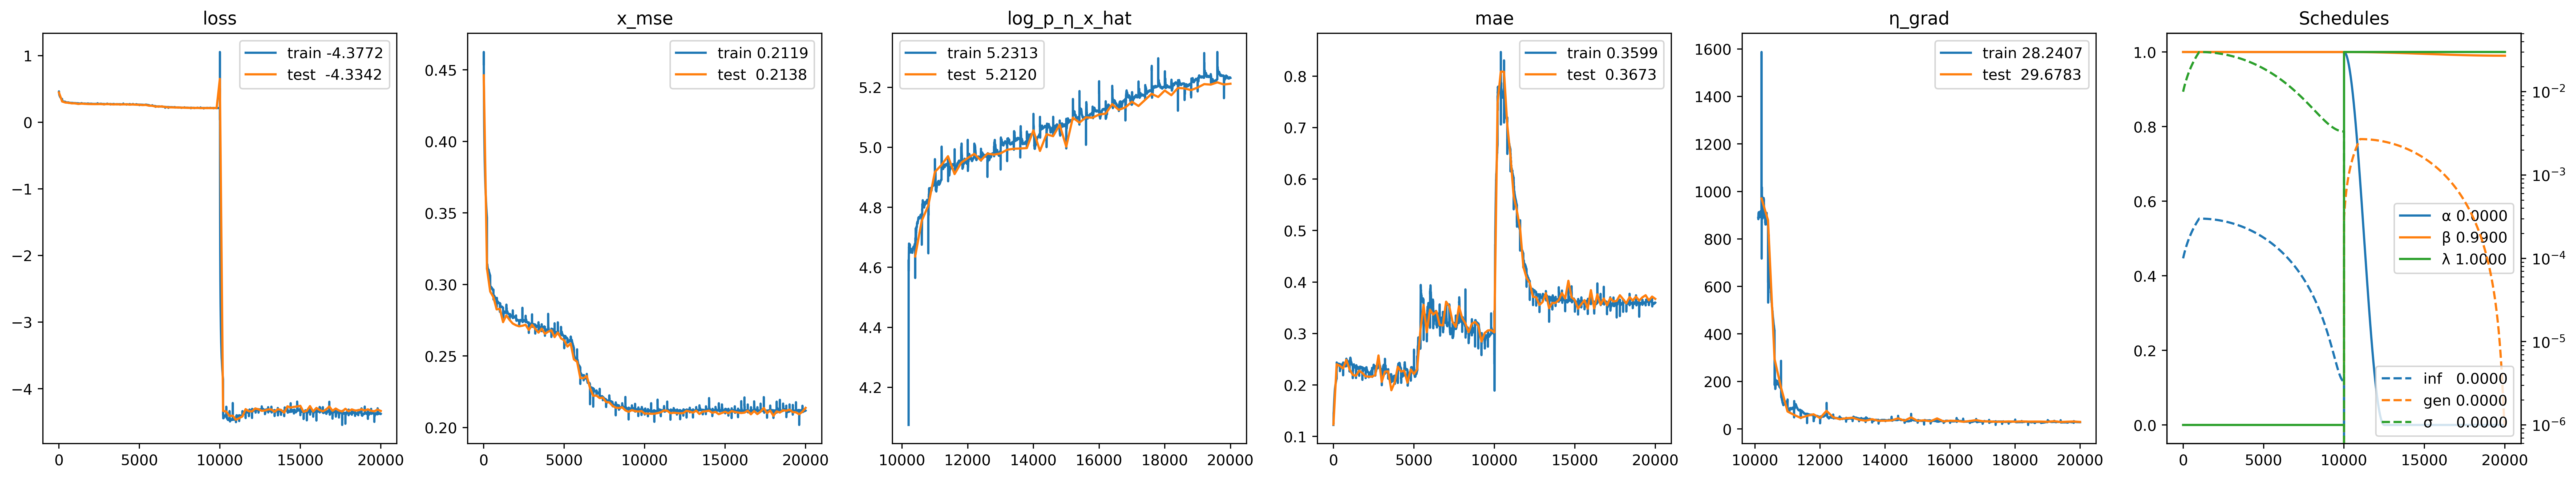

In [12]:
# plot the training history
steps, loss, x_mse, log_p_η_x_hat, mae, η_grad, λ, α, β, lr_inf, lr_gen, lr_σ, grad_norm = history.collect(
    "steps", "loss", "x_mse", "log_p_η_x_hat", "mae", "η_grad", "λ", "α", "β", "lr_inf", "lr_gen", "lr_σ", "grad_norm",
)
steps_test, loss_test, x_mse_test, log_p_η_x_hat_test, mae_test, η_grad_test = history.collect(
    "steps", "loss_test", "x_mse_test", "log_p_η_x_hat_test", "mae_test", "η_grad_test"
)

n_plots = 6
fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5), dpi=400)

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")

axs[1].plot(steps, x_mse, label=f"train {x_mse[-1]:.4f}")
axs[1].plot(steps_test, x_mse_test, label=f"test  {x_mse_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("x_mse")


second_half = lambda x, b: x[len(x) // 2 + b:]

axs[2].plot(second_half(steps, 200), second_half(log_p_η_x_hat, 200), label=f"train {log_p_η_x_hat[-1]:.4f}")
axs[2].plot(second_half(steps_test, 2), second_half(log_p_η_x_hat_test, 2), label=f"test  {log_p_η_x_hat_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("log_p_η_x_hat")

axs[3].plot(steps, mae, label=f"train {mae[-1]:.4f}")
axs[3].plot(steps_test, mae_test, label=f"test  {mae_test[-1]:.4f}")
axs[3].legend()
axs[3].set_title("mae")

axs[4].plot(second_half(steps, 100), second_half(η_grad, 100), label=f"train {η_grad[-1]:.4f}")
axs[4].plot(second_half(steps_test, 1), second_half(η_grad_test, 1), label=f"test  {η_grad_test[-1]:.4f}")
axs[4].legend()
axs[4].set_title("η_grad")

axs[5].plot(steps, α, label=f"α {α[-1]:.4f}")
axs[5].plot(steps, β, label=f"β {β[-1]:.4f}")
axs[5].plot(steps, λ, label=f"λ {λ[-1]:.4f}")
axs[5].legend()
axs[5].set_title("Schedules")

ax5_twin = axs[5].twinx()
ax5_twin.plot(steps, lr_inf, "--", label=f"inf   {lr_inf[-1]:.4f}")
ax5_twin.plot(steps, lr_gen, "--", label=f"gen {lr_gen[-1]:.4f}")
ax5_twin.plot(steps, lr_σ, "--", label=f"σ     {lr_σ[-1]:.4f}")
ax5_twin.legend(loc="lower right")
ax5_twin.set_yscale("log")

plt.show()

In [13]:
# best_state = checkpoints.restore_checkpoint(ckpt_dir='checkpoint', target=state)
# best_state.step

In [14]:
jax.nn.softplus(final_state.params['inference_net']['σ_']).mean()

Array(8.097647e-05, dtype=float32)

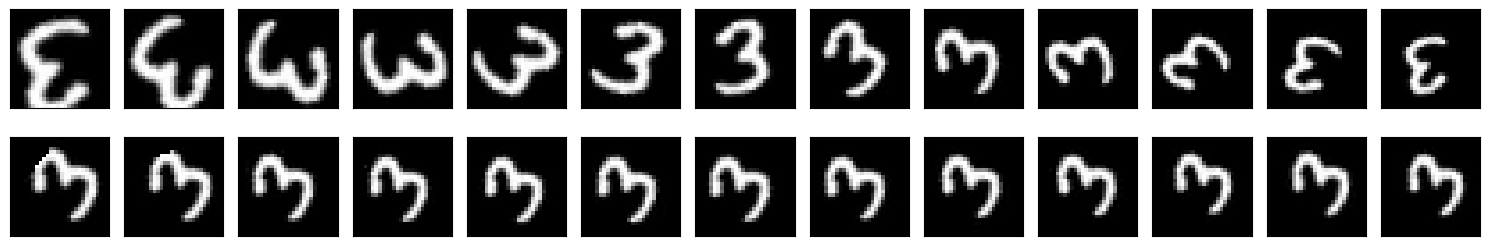

In [15]:
val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

x_ = val_batch['image'][0][14]

def get_proto(x):
    η, _ = model.apply({"params": final_state.params},
                            x, train=False, rngs={"sample": rng})
    xhat = transform_image(x, -η)
    return xhat, η

for mask in [
    # jnp.array([0, 0, 1, 0, 0]),
    # jnp.array([1, 1, 0, 0, 0]),
    # jnp.array([0, 0, 0, 1, 1]),
    jnp.array([1, 1, 1, 1, 1])
]:

    transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
        x_,
        jnp.linspace(-jnp.array(config.model.bounds) * mask, jnp.array(config.model.bounds) * mask, 13)
    )

    xhats, ηs = jax.vmap(get_proto)(transformed_xs)

    fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

    for ax, x in zip(axs[0], list(transformed_xs)):
        ax.imshow(rescale_for_imshow(x), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    for ax, xhat in zip(axs[1], list(xhats)):
        ax.imshow(rescale_for_imshow(xhat), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [16]:
from scipy.stats import gaussian_kde

p_H_X_hat, p_H_X_hat_vars = model.bind({"params": final_state.params}).generative_net.unbind()
q_H_X, q_H_X_vars = model.bind({"params": final_state.params}).inference_net.unbind()

# function to plot the histograms of p(η|x_hat) in each dimmension
def plot_hists(x, n=10_000):
    q_H_x = q_H_X.apply(q_H_X_vars, x)
    ηs_q, log_probs = q_H_x.sample_and_log_prob(seed=random.PRNGKey(0), sample_shape=(n))
    η = ηs_q[jnp.argmax(log_probs)]
    xhat = transform_image(x, -η)

    p_H_x_hat = p_H_X_hat.apply(p_H_X_hat_vars, xhat)
    
    ηs_p = p_H_x_hat.sample(seed=random.PRNGKey(0), sample_shape=(10_000,))

    D = p_H_x_hat.event_shape[0]
    fig, axs = plt.subplots(1, D + 2, figsize=(3*(D+2), 3))

    axs[0].imshow(rescale_for_imshow(x), cmap='gray')
    axs[1].imshow(rescale_for_imshow(xhat), cmap='gray')

    for i, ax in enumerate(axs[2:]):
        x = np.linspace(config.model.bounds[i] - 1e-5, -config.model.bounds[i] + 1e-5, 1000)

        # plot p(η|x_hat)
        ax.hist(ηs_p[:, i], bins=100, density=True, alpha=0.5, color="C0")
        kde = gaussian_kde(ηs_p[:, i])
        ax.plot(x, kde(x), color="C0")

        # make a axvline to plot η, make the line dashed
        ax.axvline(η[i], color="C1", linestyle="--")
        # make a twin axis to plot q(η|x)
        ax2 = ax.twinx()
        ax2.hist(ηs_q[:, i], bins=100, density=True, alpha=0.5, color="C1")
        kde = gaussian_kde(ηs_q[:, i])
        ax2.plot(x, kde(x), color="C1")

        ax.set_title(f"dim {i}")
        ax.set_xlim(-config.model.bounds[i], config.model.bounds[i])

    plt.tight_layout()
    plt.show()

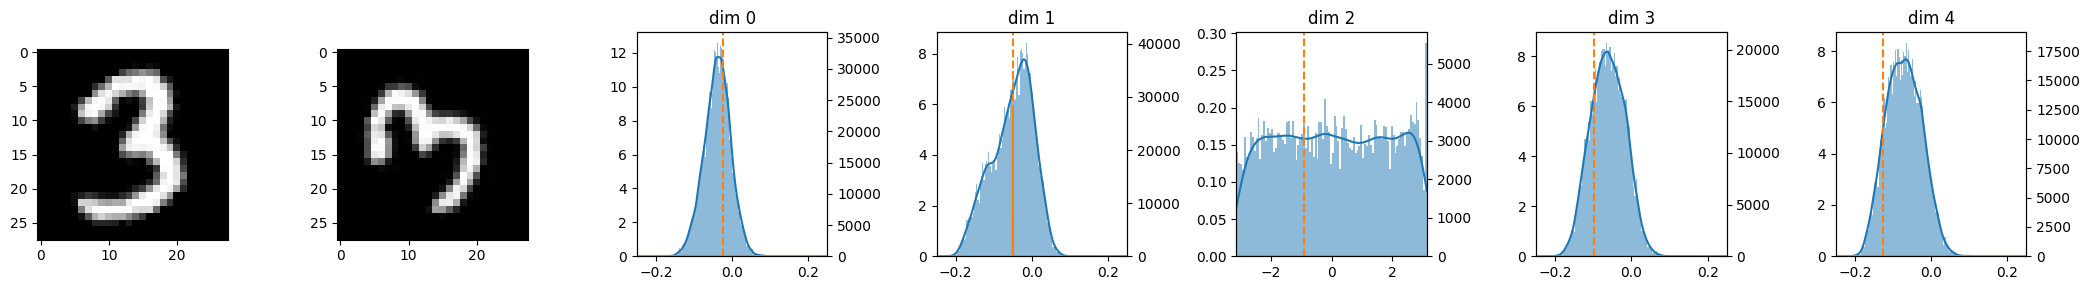

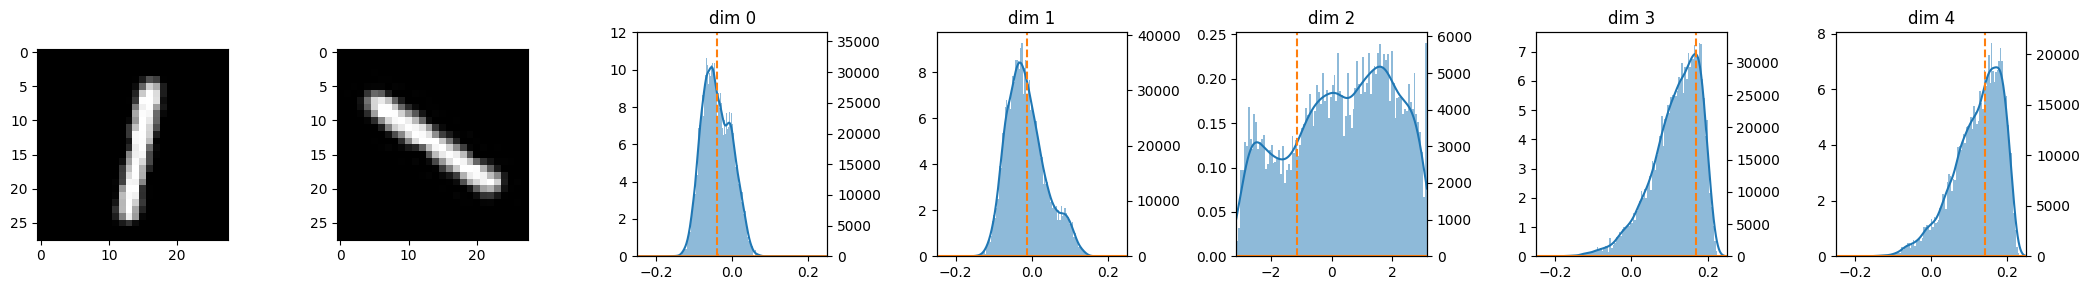

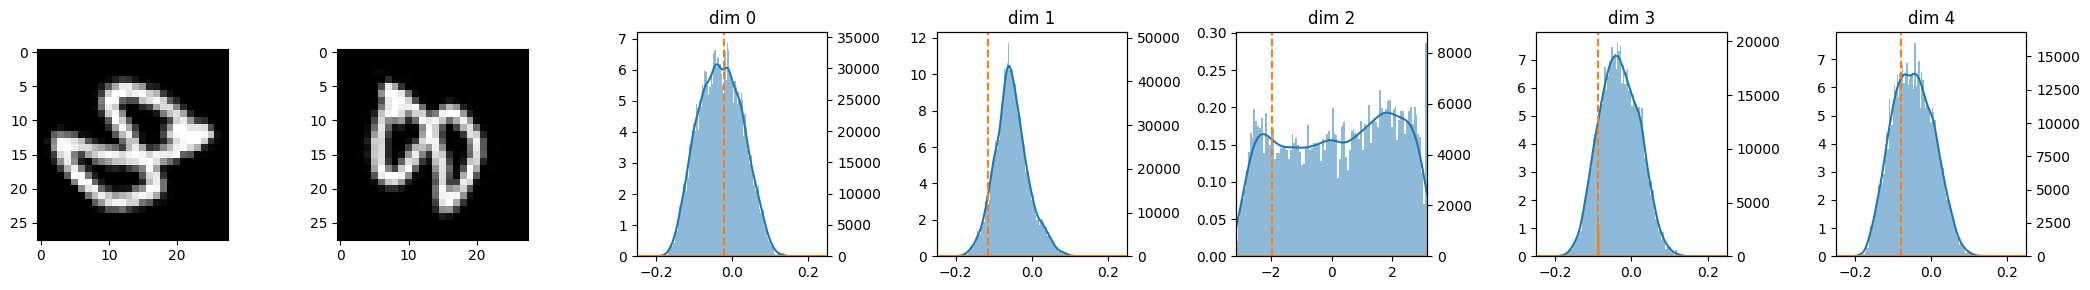

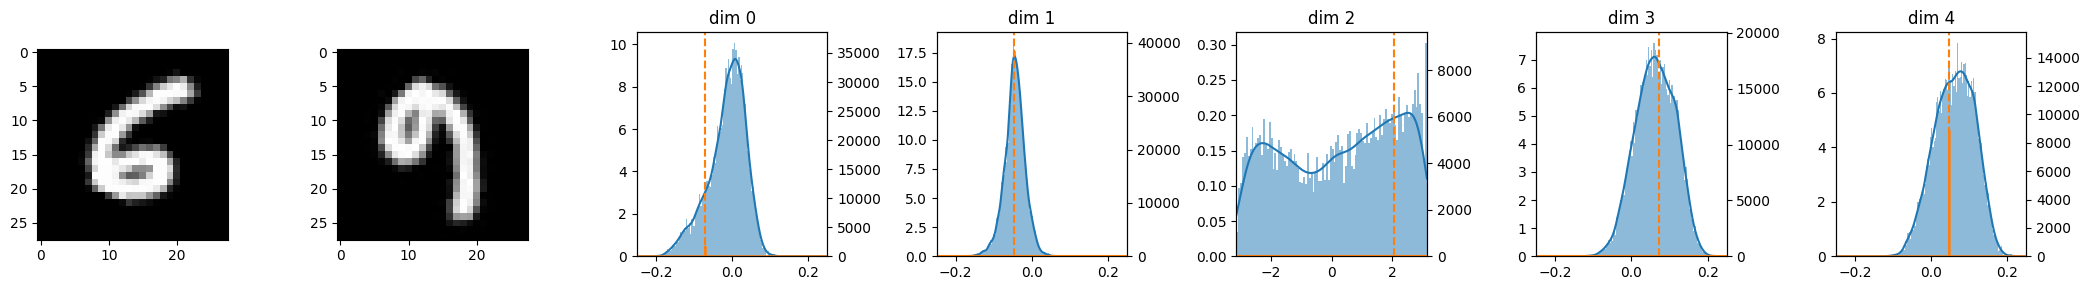

In [17]:
plot_hists(val_batch['image'][0][14], n=1_000)
plot_hists(val_batch['image'][0][1], n=1_000)
plot_hists(val_batch['image'][0][4], n=1_000)
plot_hists(val_batch['image'][0][9], n=1_000)

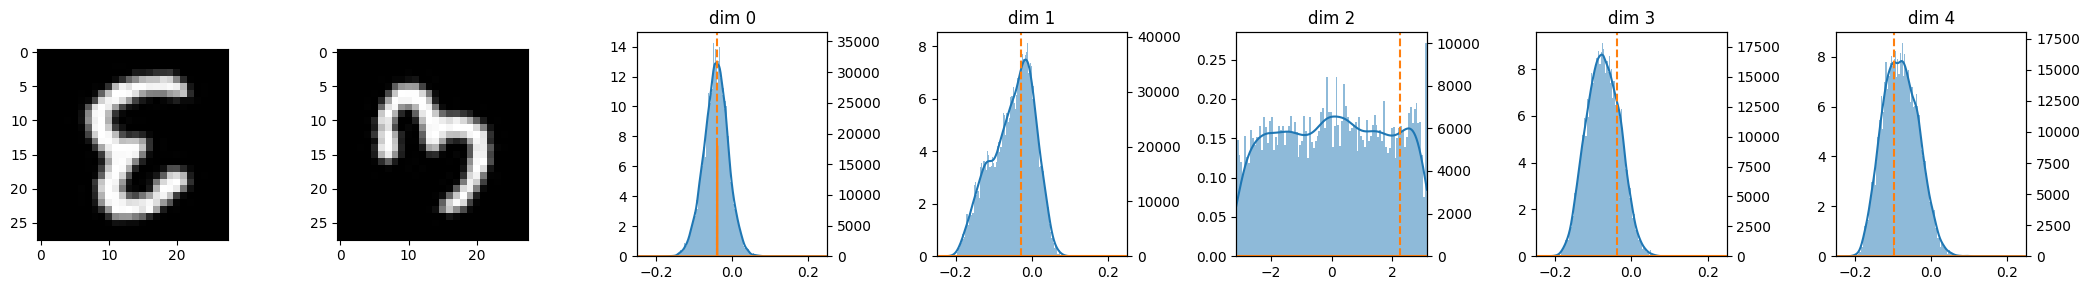

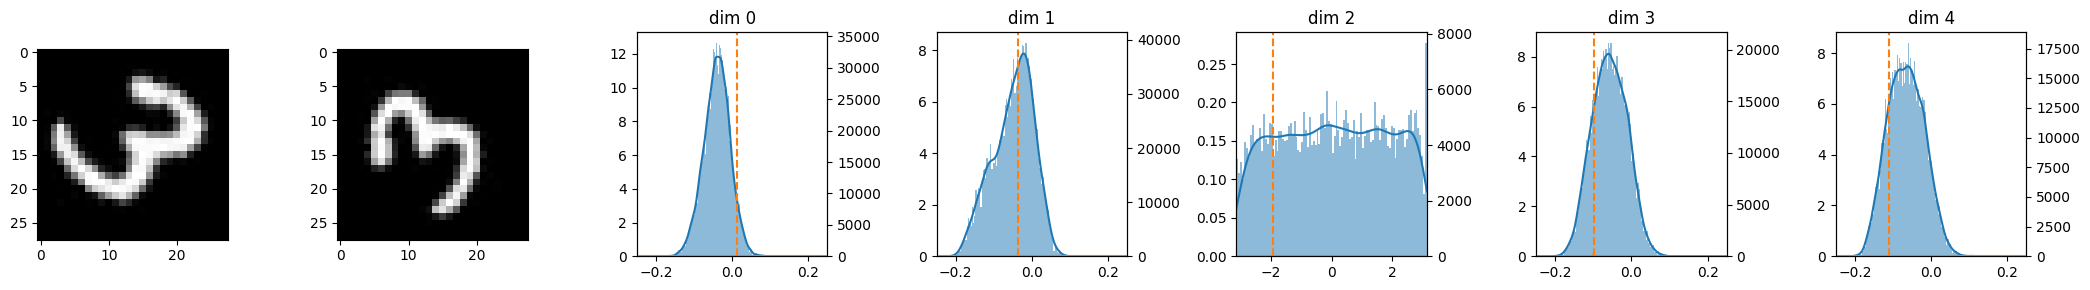

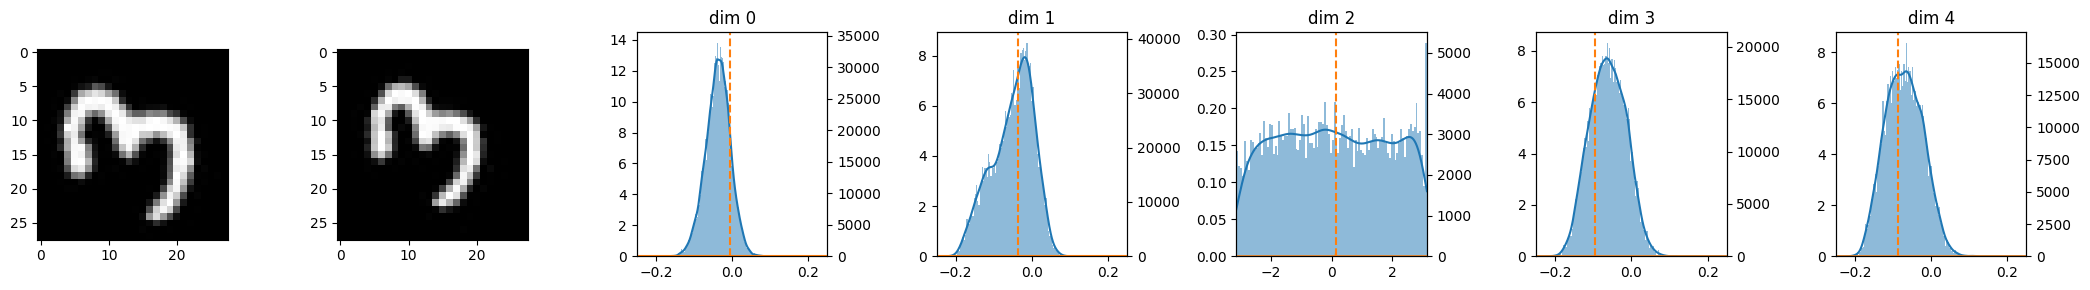

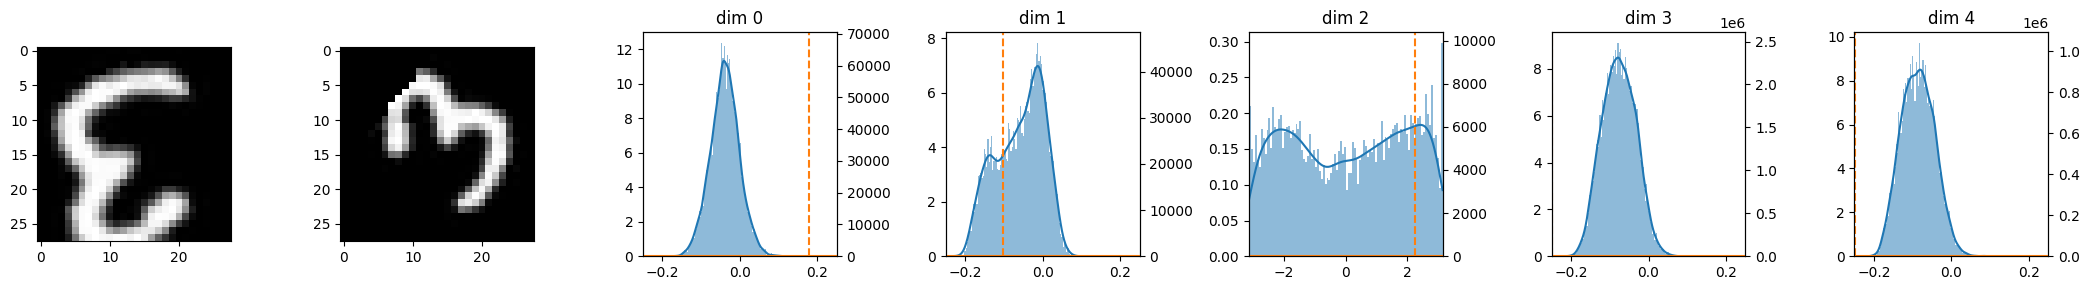

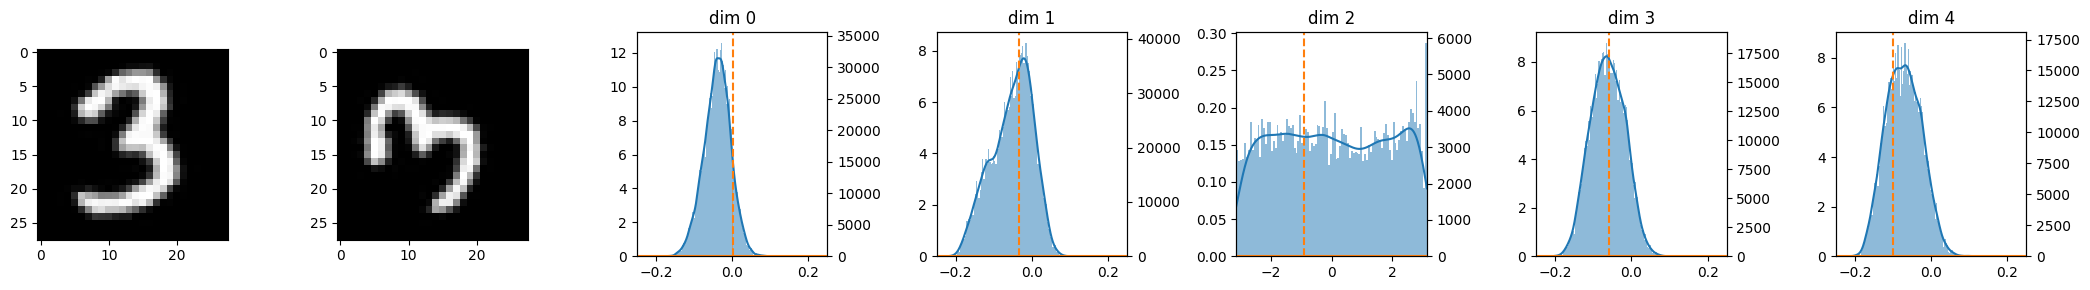

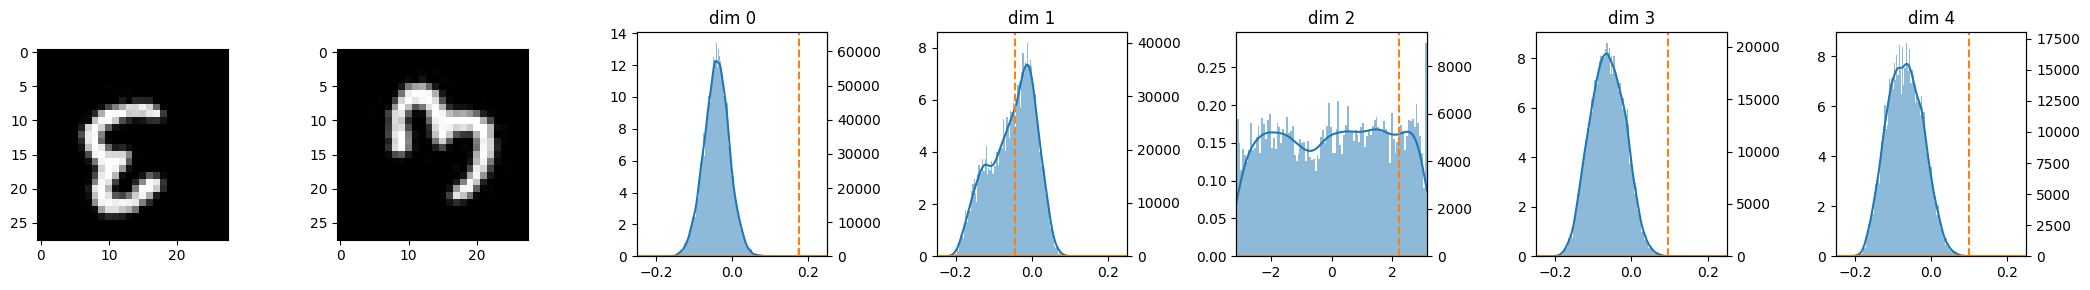

In [18]:
full_mask = jnp.array([1, 1, 1, 1, 1])
rot_mask = jnp.array([0, 0, 1, 0, 0])
transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
    x_,
    jnp.concatenate((
        jnp.linspace(-jnp.array(config.model.bounds) * rot_mask, jnp.array(config.model.bounds) * rot_mask, 4)[:3],
        jnp.linspace(-jnp.array(config.model.bounds) * full_mask, jnp.array(config.model.bounds) * full_mask, 3),
    ))
)

for x in transformed_xs:
    plot_hists(x, n=1_000)

[]

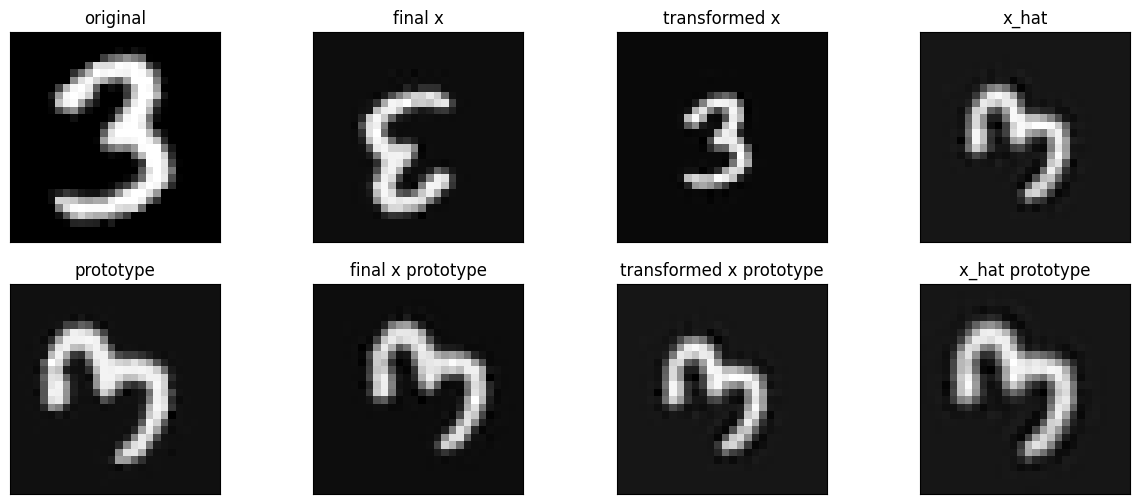

In [19]:
# make a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# plot the original image
axs[0, 0].imshow(x_, cmap='gray')
axs[0, 0].set_title("original")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(x_)
axs[1, 0].imshow(xhat, cmap='gray')
axs[1, 0].set_title("prototype")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# plot x
axs[0, 1].imshow(x, cmap='gray')
axs[0, 1].set_title("final x")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(x)
axs[1, 1].imshow(xhat, cmap='gray')
axs[1, 1].set_title("final x prototype")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

# transform again and plot the result
xx = transform_image(x, jnp.array(config.model.bounds))
axs[0, 2].imshow(xx, cmap='gray')
axs[0, 2].set_title("transformed x")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(xx)
axs[1, 2].imshow(xhat, cmap='gray')
axs[1, 2].set_title("transformed x prototype")
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

# use that xhat as x
axs[0, 3].imshow(xhat, cmap='gray')
axs[0, 3].set_title("x_hat")
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(xhat)
axs[1, 3].imshow(xhat, cmap='gray')
axs[1, 3].set_title("x_hat prototype")
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
